連続体方程式（通常は偏微分方程式、PDE）を物理インフォームドニューラルネットワーク（PINNs）の損失関数に組み込む際のプロセスは、モデルが物理的な法則に従う解を学習できるようにするために重要です。以下に、その基本的な手順を説明します。

### 1. 連続体方程式の定義

まず、解こうとしている連続体方程式（PDE）を定義します。一般的なPDEの形式は次のようになります：

$$ \mathcal{L}(u(x,t)) = 0, $$

ここで、$\mathcal{L}$は偏微分演算子で、$u(x,t)$は解となる関数です。例えば、1次元の熱方程式の場合は次のように書けます：

$$ \frac{\partial u(x,t)}{\partial t} - \alpha \frac{\partial^2 u(x,t)}{\partial x^2} = 0, $$

ここで、$\alpha\$は熱拡散係数です。

### 2. ニューラルネットワークの構造

PINNsはニューラルネットワークを用いて解を近似します。ニューラルネットワークの入力は空間座標 $x$ と時間 $t$ で、出力は関数 $u(x,t)$ です。ネットワークは通常、以下のような構造を持ちます：

- 入力層：$x$ と $t$
- 隠れ層：活性化関数（例: ReLU）
- 出力層：$u(x,t$) の予測値

### 3. 損失関数の構築

損失関数は、ニューラルネットワークの出力が連続体方程式を満たすように設計します。具体的には、以下のような損失関数を定義します：

$$ L_{\text{total}} = L_{\text{PDE}} + L_{\text{BC}} + L_{\text{IC}}. $$

- **PDE損失項** $L_{\text{PDE}}$：ネットワークの出力がPDEを満たすようにする損失です。具体的には、次の手順で計算します：

  1. ネットワークの出力 $u(x,t$) から、PDEに必要な偏微分を計算します（例えば、$\frac{\partial u}{\partial t}$ や $\frac{\partial^2 u}{\partial x^2}$）。
  2. PDEの左辺 $\mathcal{L}(u(x,t)$) を計算し、その結果がゼロに近くなるようにします。
  3. 損失として、PDEの残差（$\mathcal{L}(u(x,t))$）の二乗和を使用します。

  例えば、熱方程式の場合のPDE損失は次のように書けます：

  $$ L_{\text{PDE}} = \frac{1}{N_{\text{PDE}}} \sum_{i=1}^{N_{\text{PDE}}} \left(\frac{\partial u(x_i, t_i)}{\partial t} - \alpha \frac{\partial^2 u(x_i, t_i)}{\partial x^2} \right)^2, $$

  ここで、$(x_i, t_i)$ はランダムにサンプリングされたポイントです。

- **境界条件損失項** $L_{\text{BC}}$：境界条件（例えば、空間の端点での値やフラックス条件）を満たすようにする損失です。

  例えば、$x = 0$ と $x = L$ での境界条件が $u(0, t) = u_L$ と $u(L, t) = u_R$ である場合、次のように計算します：

  $$ L_{\text{BC}} = \frac{1}{N_{\text{BC}}} \sum_{j=1}^{N_{\text{BC}}} \left(u(x_j, t_j) - u_{\text{BC}}(x_j, t_j) \right)^2, $$

  ここで、$u_{\text{BC}}$ は境界条件に従った値です。

- **初期条件損失項** $L_{\text{IC}}$：初期条件（例えば、$t=0$ のときの $u(x,0)$ の値）を満たすようにする損失です。初期条件損失は次のように書けます：

  $$ L_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{k=1}^{N_{\text{IC}}} \left(u(x_k, 0) - u_{\text{IC}}(x_k) \right)^2, $$

  ここで、$u_{\text{IC}}$ は初期条件に従った値です。

### 4. トレーニング

PINNsのトレーニングは、損失関数 $L_{\text{total}}$ を最小化することによって行われます。通常、確率的勾配降下法（SGD）やそのバリエーション（例えばAdam）を使用します。トレーニングデータには、ランダムにサンプリングした空間座標と時間座標が含まれ、これらに対してネットワークの出力がPDE、境界条件、初期条件を満たすように調整されます。

これが連続体方程式をPINNsの損失関数に組み込む基本的な流れです。具体的な実装には、数値微分、サンプリング戦略、ネットワークのアーキテクチャなどの詳細な調整が必要です。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# ニューラルネットワークの定義
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = layers
        self.fc_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = self.activation(layer(x))
        x = self.fc_layers[-1](x)
        return x

In [7]:
# 偏微分の計算
def derivatives(net, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = net(torch.cat((x, t), dim=1))

    u_t = torch.autograd.grad(outputs=u, inputs=t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x),
                               create_graph=True, retain_graph=True)[0]

    return u, u_t, u_x, u_xx

In [8]:
# 損失関数の定義
def loss_function(net, x, t, x_bc, t_bc, u_bc, x_ic, u_ic):
    u, u_t, u_x, u_xx = derivatives(net, x, t)

    # PDE損失
    f_pde = u_t - alpha * u_xx
    loss_pde = torch.mean(f_pde**2)

    # 境界条件損失
    u_bc_pred = net(torch.cat((x_bc, t_bc), dim=1))
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 初期条件損失
    u_ic_pred = net(torch.cat((x_ic, torch.zeros_like(x_ic)), dim=1))
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    return loss_pde + loss_bc + loss_ic

In [5]:
## 動き確認

N_bc = 5
N_ic  =5
L = 1
T = 1
x_bc = torch.cat((torch.zeros((N_bc, 1)), torch.full((N_bc, 1), L)), dim=0)
t_bc = torch.cat((torch.rand((N_bc, 1)) * T, torch.rand((N_bc, 1)) * T), dim=0)
x_ic = torch.rand((N_ic, 1), dtype=torch.float32) * L

u_bc = torch.zeros((N_bc*2, 1), dtype=torch.float32)  # Example boundary condition
u_ic = torch.sin(np.pi * x_ic).float()  # Example initial condition

layers = [2, 50, 50, 50, 1]
net = PINN(layers)

u_bc_pred = net(torch.cat((x_bc, t_bc), dim=1))
loss_bc = torch.mean((u_bc_pred - u_bc)**2)

print(torch.cat((x_bc, t_bc), dim=1))
print(u_bc_pred)
print(loss_bc)

tensor([[0.0000, 0.5866],
        [0.0000, 0.4530],
        [0.0000, 0.9329],
        [0.0000, 0.4067],
        [0.0000, 0.3761],
        [1.0000, 0.4286],
        [1.0000, 0.8995],
        [1.0000, 0.4409],
        [1.0000, 0.1200],
        [1.0000, 0.0644]])
tensor([[0.1200],
        [0.1206],
        [0.1156],
        [0.1207],
        [0.1207],
        [0.1076],
        [0.1016],
        [0.1074],
        [0.1103],
        [0.1107]], grad_fn=<AddmmBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)


In [9]:
# 学習
def train(net, optimizer, num_epochs=10000):
    for epoch in range(num_epochs):
        net.train()

        optimizer.zero_grad()

        # サンプリング
        x = torch.rand((N_points, 1), dtype=torch.float32) * L
        t = torch.rand((N_points, 1), dtype=torch.float32) * T

        # 境界条件と初期条件のサンプル
        x_bc = torch.cat((torch.zeros((N_bc, 1)), torch.full((N_bc, 1), L)), dim=0)
        t_bc = torch.cat((torch.rand((N_bc, 1)) * T, torch.rand((N_bc, 1)) * T), dim=0)
        x_ic = torch.rand((N_ic, 1), dtype=torch.float32) * L

        u_bc = torch.zeros((2 * N_bc, 1), dtype=torch.float32)  # Example boundary condition
        u_ic = torch.sin(np.pi * x_ic).float()  # Example initial condition

        # 損失計算
        loss = loss_function(net, x, t, x_bc, t_bc, u_bc, x_ic, u_ic)

        # 勾配計算と更新
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# ハイパーパラメータとモデルの初期化
L = 1.0  # 空間範囲
T = 1.0  # 時間範囲
alpha = 0.01  # 熱拡散係数

# サンプル数の設定
N_points = 1000
N_bc = 100
N_ic = 100

layers = [2, 50, 50, 50, 1]
net = PINN(layers)

optimizer = optim.Adam(net.parameters(), lr=0.001)

train(net, optimizer)

Epoch 0, Loss: 0.6899396181106567
Epoch 1000, Loss: 3.9497190300608054e-05
Epoch 2000, Loss: 1.0083235792990308e-05
Epoch 3000, Loss: 9.8952205007663e-06
Epoch 4000, Loss: 6.512439540529158e-06
Epoch 5000, Loss: 2.2771815565647557e-05
Epoch 6000, Loss: 3.861536970362067e-05
Epoch 7000, Loss: 2.8539172944874736e-06
Epoch 8000, Loss: 0.00013481374480761588
Epoch 9000, Loss: 1.4463257684838027e-05


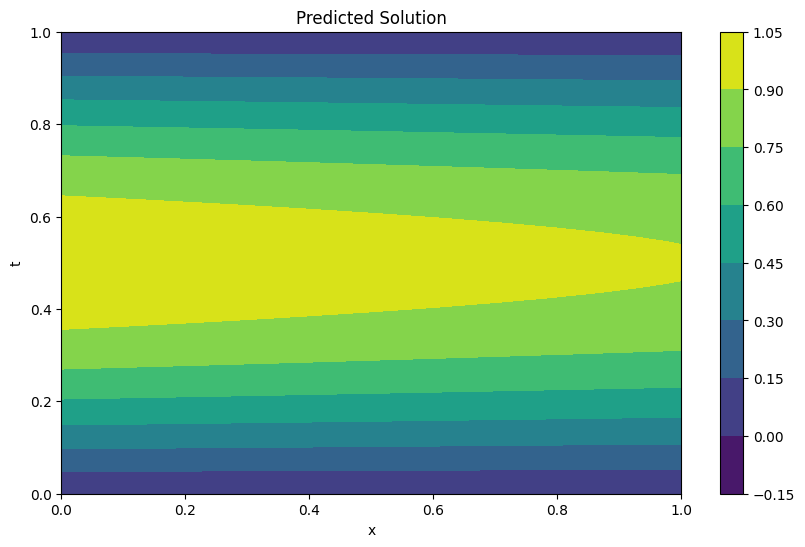

x= (10000,)
t= (10000,)
u= (10000, 1)
np.unique(x) (100,)
X= (100, 100)
T= (100, 100)


In [28]:
# 結果の可視化
def plot_solution(net, x, t):
    with torch.no_grad():
        net.eval()
        # ネットワークの出力を計算
        # 全組み合わせ[10000, 2]で、出力[10000, 1]を得る
        u = net(torch.cat((x, t), dim=1)).numpy()

        # x と t を 1D 配列に変換 ⇒ x= (10000,),t= (10000,)
        x = x.numpy().flatten()
        t = t.numpy().flatten()

        # メッシュグリッドの生成
        # 再度、[100, 100]にする、x,tをダブり抜きしてからmeshgrid
        X, T = np.meshgrid(np.unique(x), np.unique(t))

        # u を 2D 配列に変換 [10000, 1]⇒[100, 100]
        U = u.reshape(len(np.unique(t)), len(np.unique(x)))

        # プロット
        plt.figure(figsize=(10, 6))
        contour = plt.contourf(X, T, U, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('t')
        plt.title('Predicted Solution')
        plt.show()

# x と t の範囲を設定
x_plot = torch.linspace(0, L, 100).reshape(-1, 1) # [100, 1]
t_plot = torch.linspace(0, T, 100).reshape(-1, 1) # [100, 1]

# メッシュグリッドを作成
# X_g は x_plot の値を列方向に繰り返した行列
# Y_g は y_plot の値を行方向に繰り返した行列
# X_g=[100, 100],T_g=[100, 100]
X_g, T_g = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing='ij')

# Flatten 行優先で1行目のあとに2行目を並べる
# cat dim=1 で全組み合わせ (n,2)
X_flat = X_g.reshape(-1, 1) # [10000, 1]
T_flat = T_g.reshape(-1, 1) # [10000, 1]

# 結果をプロット
plot_solution(net, X_flat, T_flat)


X= (100, 100)
[[ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 ...
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]]
Y= (100, 100)
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.1010101  0.1010101  0.1010101 ...  0.1010101  0.1010101  0.1010101]
 [ 0.2020202  0.2020202  0.2020202 ...  0.2020202  0.2020202  0.2020202]
 ...
 [ 9.7979798  9.7979798  9.7979798 ...  9.7979798  9.7979798  9.7979798]
 [ 9.8989899  9.8989899  9.8989899 ...  9.8989899  9.8989899  9.8989899]
 [10.        10.        10.        ... 10.        10.        10.       ]]
Z= (100, 100)


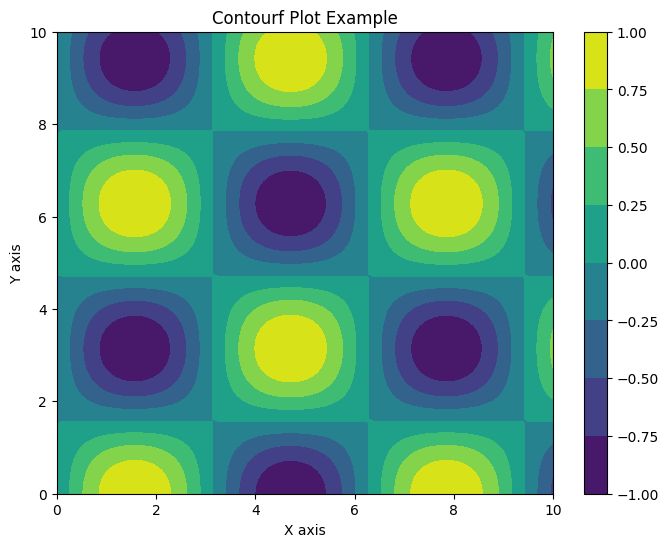

In [31]:
# meshgridの動き確認
# データの準備
x = np.linspace(0, 10, 100)  # x 軸の範囲
y = np.linspace(0, 10, 100)  # y 軸の範囲
X, Y = np.meshgrid(x, y)     # グリッドの生成
Z = np.sin(X) * np.cos(Y)    # Z 値の計算

print('X=',X.shape) # 行方向が同じ値
print(X)
print('Y=',Y.shape) # 列方向が同じ値
print(Y)
print('Z=',Z.shape)

# プロット
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, cmap='viridis')  # 塗りつぶし等高線プロット
plt.colorbar(contour)  # カラーバーの追加
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Contourf Plot Example')
plt.show()
